# TL;DR

* The change to the Ethereum fee market introduced by EIP-1559 promised better gas pricing and faster transaction inclusion.
* The transition from legacy to new "type 2" transactions is still underway, and while some dapps use pre-London libraries for their UIs, users cannot realise the full benefits of the update.
* Users of type 2 transactions reliably pay less than those using the legacy type.
* Variability in the fee market is down significantly over short time periods. This implies that the market is more efficient — users *are* less likely to overpay for transactions.
* Evidence of faster transaction inclusion is hard to find. It may be that wallet providers had already effectively solved the "stuck" transaction problem, by using generous buffers on transaction price estimates.
* However, since deploying EIP-1559, all users can get the benefit of fast inclusion *without* the risk of overpaying.

# Introduction

Ethereum's London hard fork on 5 August 2021 introduced a major change to the mechanics behind transaction fees — the widely-discussed Ethereum Improvement Proposal (EIP) 1559. This was the culmination of a long period of development, building on fee market reform ideas first shared by Vitalik Buterin [back in 2014](https://blog.ethereum.org/2014/02/01/on-transaction-fees-and-the-fallacy-of-market-based-solutions/) and developed into something like the form eventually used for EIP-1559 in a [July 2018 post](https://ethresear.ch/t/first-and-second-price-auctions-and-improved-transaction-fee-markets/2410).

Both the 2018 article and [the text of the EIP itself](https://eips.ethereum.org/EIPS/eip-1559) emphasised the benefits that would accrue to *users* of Ethereum as a result of the change to a fee market which would provide an estimate for the market clearing price for gas (the unit for metering Ethereum's computational resources, consumed in transaction processing). Two benefits were identified:

1. by moving from a "first price auction" model to a "posted price" for inclusion, users would be less likely to overpay for their transactions;
1. users could expect prompt inclusion, avoiding the problem of stuck transactions (this had been a recurring problem due to the highly volatile nature of the fee market).

While the 2018 article noted that the mechanism would lead to the protocol capturing some of the transaction revenue, the idea of destroying (*burning*) the captured revenue was mentioned as only one possibility of several — albeit fee burn was by far the simplest of these to implement. The eventual EIP made fee-burn the preferred option, and in [my August 2020 article](https://pintail.medium.com/ethereum-fee-market-reform-eip-1559-as-a-question-of-fairness-567c52dac017) on the subject, I argued that this was also the fairest thing to do. Ultimately, Ethereum client devs were persuaded of EIP-1559's merits, and were reassured when [a study](https://timroughgarden.org/papers/eip1559.pdf) by Tim Roughgarden showed that incentives for miners and impediments to various game-theortic attacks were just as strong under EIP-1559 as the previous system.

Since then, much of the coverage of EIP-1559 has focused on the fee-burn aspect of the change, and its impact on net issuance of ether (and, whether implicitly or explicitly, the price of ether). A notable exception to this was an article from [Coinbase](https://blog.coinbase.com/the-technical-benefits-of-eip-1559-c41bb85f5924) which demonstrated the savings they were making by adopting the new transaction type. 

In this article however, we'll take a look at the two purported advantages of EIP-1559 as outlined above, and try to answer a couple of questions, to evaluate the change on the basis for which it was made:

1. has EIP-1559 reduced overpayment of transaction fees?
1. are users getting their transactions included more quickly since the change?

# Fee Market Transition

The transaction type introduced by EIP-1559 requires users to specify two parameters to determine the gas price they pay, per unit gas. These are the fee cap (`maxFeePerGas`) and and a priority fee (`maxPriorityFeePerGas`) also known as "miner tip". The fee actually paid by the user is then the sum of the current basefee (`baseFeePerGas`) — effectively a protocol-determined [congestion price](https://barnabe.substack.com/p/congestion-control-and-eip1559) (which is burned) — and the priority fee, which goes to the miner who includes the transaction. If the current block's basefee is higher than the transaction's fee cap, then the transaction cannot be included until the basefee comes down.

Changing the format for transactions in this way could have been highly disruptive for users, since wallet UIs would need to change to allow users to submit transactions in the new style. To try and minimise this disruption, the EIP-1559 specification allowed earlier transaction types to be interpreted as EIP-1559 transactions. Users submitting legacy transactions would not enjoy the benefits of EIP-1559, but could still transact in a similar way to before. Internally, the way this was done was for legacy transactions to be interpreted as having *both* the fee cap and priority fee set as equal to the "gas price" provided by the user. What this meant was that the miner would receive all excess from these transactions, after subtracting the basefee, rather than being limited to a user-specified priority fee/tip, which would usually be much lower.

The chart below shows this transition occurring. Before the London hard fork, indicated by the dashed red line, all transactions are of the legacy type (in blue). After London we see a fairly rapid transition during August to "type 2" transactions (in green). From September onwards, the transition is much more gradual, presumably due to a long tail of users tied to various legacy interfaces. There's a third category of transaction shown on the chart in orange. These are "type 2" transactions which have their fee cap and priority fee set to the same value. That is, they are EIP-1559 style transactions which specify the relevant parameters, yet they are set *as though* it were a legacy transaction. It turns out that this is mostly a result of some dapps using an outdated version of [web3.js](https://github.com/ChainSafe/web3.js) (h/t Tim Beiko).

The other thing to note is the slight increase in daily gas used which occurs at the London hard fork. This is because the 15M gas *limit* has become a gas *target* — average per-block gas usage is at the 15M level, whereas previously it was always a small amount below this level (due to gas "packing" issues, empty blocks or other miner inefficiencies resulting in blocks being slightly under-full). Vitalik Buterin [has written on this subject](https://www.reddit.com/r/ethereum/comments/p4nloh/why_has_the_chain_capacity_increased_by_9_after/?utm_source=share&utm_medium=web2x&context=3) in more detail.

In [1]:
# imports, constants, definitions

import time
import math
import json
import csv
import requests
import pickle
from jsonrpcclient import request
from matplotlib import pyplot as plt, ticker
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
from numpy import median, quantile
import pandas as pd
from web3 import Web3

ERIGON_URL = "http://192.168.1.104:8545/"
#w3 = Web3(Web3.HTTPProvider(ERIGON_URL))
LONDON_BLOCKNUM = 12965000
START_BLOCKNUM = LONDON_BLOCKNUM - 750000
END_BLOCKNUM = LONDON_BLOCKNUM + 750000

first_block_ts = 1618095148
last_block_ts  = 1638278548

start_date = datetime.utcfromtimestamp(first_block_ts).date()
end_date = datetime.utcfromtimestamp(last_block_ts).date()
num_days = (end_date - start_date).days + 1
        
london_dt = datetime(2021,8,5,12,33,42)

def gas_quantiles(txs, numquantiles):
    quantiles = [None] * (numquantiles - 1)
    cumulative_gas = 0
    total_gas = sum(tx.gas_used for tx in txs)
    for tx in sorted(txs, key=lambda k: k.gas_price):
        cumulative_gas += tx.gas_used
        for i, q in enumerate(quantiles):
            if q is None and cumulative_gas >= total_gas * (i + 1) / numquantiles:
                quantiles[i] = tx.gas_price
    
    return quantiles

class Tx:   
    def __init__(self, tx_type, gas_used, gas_price):
        self.tx_type = tx_type
        self.gas_used = gas_used
        self.gas_price = gas_price

class Block:
    def __init__(self, blocknum):
        self.blocknum = blocknum
        batch_request = [
            request("eth_getBlockByNumber", [blocknum, True]),
            request("eth_getBlockReceipts", [blocknum])
        ]
        
        response = requests.post(ERIGON_URL, json=batch_request).json()
        self.ts = int(response[0]['result']['timestamp'], base=16)
        self.dt = datetime.utcfromtimestamp(self.ts)
        tx_json = response[0]['result']['transactions']
        receipts_json = response[1]['result']
        
        if len(tx_json) > 0:
            tmp = sorted(
                zip(tx_json, receipts_json),
                key=lambda k: int(k[1]['effectiveGasPrice'], base=16)
            )
            tx_json, receipts_json = zip(*tmp)
            
        self.txs = []
        for t, r in zip(tx_json, receipts_json):
            gas_used = int(r['gasUsed'], base=16)
            tx_type = int(r['type'], base=16)
            if tx_type == 2 and (t['maxFeePerGas'] == t['maxPriorityFeePerGas']):
                tx_type = 3
            gas_price = int(r['effectiveGasPrice'], base=16)
            self.txs += [Tx(tx_type, gas_used, gas_price)]
            
class WindowSeries:
    def __init__(self, start_ts, period, numquantiles):
        self.start_ts = start_ts
        self.period = period
        self.numquantiles = numquantiles
        self.numperiods = 0
        self.block_cache = []
        self.quantile_series_legacy = []
        self.quantile_series_type2 = []
    
    def add_block(self, block):
        period_start = self.start_ts + self.period * self.numperiods
        
        if block.ts >= period_start + self.period:
            self.process_cache()
        else:
            self.block_cache += [block]
    
    def process_cache(self):
        total_legacy_gas = 0
        total_type2_gas = 0
        legacy_txs = []
        type2_txs = []
        for block in self.block_cache:
            for tx in block.txs:
                if tx.tx_type > 1:
                    total_type2_gas += tx.gas_used
                    type2_txs += [tx]
                else:
                    total_legacy_gas += tx.gas_used
                    legacy_txs += [tx]
        
        self.quantile_series_legacy += [gas_quantiles(legacy_txs, self.numquantiles)]
        self.quantile_series_type2 += [gas_quantiles(type2_txs, self.numquantiles)]
        self.block_cache = []
        self.numperiods += 1

restored_data = False
try:
    with open('gas-market-analysis.pkl', 'rb') as f:
        window_series, legacy_gas_per_day, eip1559_gas_per_day, hybrid_gas_per_day = pickle.load(f)
    restored_data = True
except:
    print('cannot open pickle file')

In [2]:
# run through blocks to get fee quantiles etc.

if not restored_data:
    period_lengths = [120, 300, 600, 1200]

    num_pre_london_periods = [
        math.ceil((london_ts - first_block.ts) / pl)
        for pl in period_lengths
    ]

    start_ts = [
        london_ts - num_periods * pl
        for num_periods, pl in zip(num_pre_london_periods, period_lengths)
    ]

    window_series = [
        WindowSeries(ts, pl, 4) for ts, pl in zip(start_ts, period_lengths)
    ]

    legacy_gas_per_day = [0] * num_days
    eip1559_gas_per_day = [0] * num_days
    hybrid_gas_per_day = [0] * num_days

    run_start_time = time.time()
    print(f"started at {datetime.utcfromtimestamp(run_start_time):%Y-%m-%d %H:%M:%S}")
    last_update = 0

    for blocknum in range(START_BLOCKNUM, END_BLOCKNUM):
        block = Block(blocknum)
        daynum = (block.dt.date() - start_date).days
        for tx in block.txs:
            if tx.tx_type == 0 or tx.tx_type == 1:
                legacy_gas_per_day[daynum] += tx.gas_used
            elif tx.tx_type == 2:
                eip1559_gas_per_day[daynum] += tx.gas_used
            elif tx.tx_type == 3:
                hybrid_gas_per_day[daynum] += tx.gas_used            
            else:
                print(f"unknown transaction type {tx.tx_type} in block {blocknum}")       

        for w in window_series:
            w.add_block(block)

        current_time = time.time()
        if current_time - last_update > 10:
            last_update = current_time
            frac = (blocknum - START_BLOCKNUM) / (END_BLOCKNUM - START_BLOCKNUM)
            runtime_str = str(timedelta(seconds=int(current_time - run_start_time)))
            print(f"block: {blocknum} runtime: {runtime_str} {100 * frac:.2f}% complete", end='\r')

    print('\n' + str(timedelta(seconds = time.time() - run_start_time)))

    with open('gas-market-analysis.pkl', 'wb') as f:
        pickle.dump((window_series, legacy_gas_per_day, eip1559_gas_per_day, hybrid_gas_per_day), f)
else:
    print("cell not executed - data previously restored")

cell not executed - data previously restored


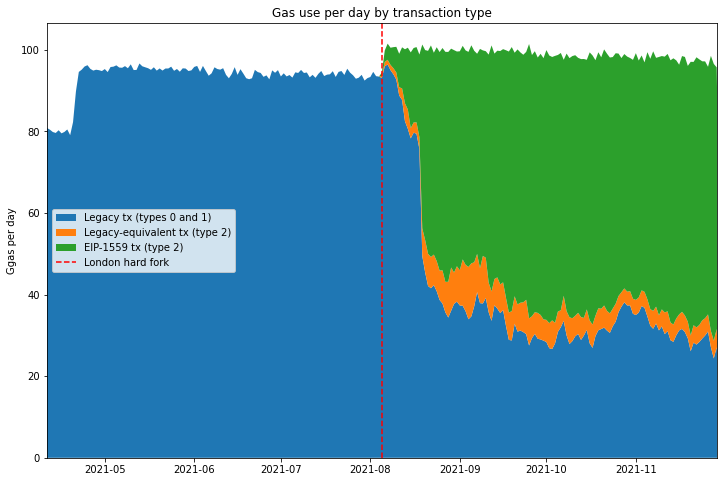

In [3]:
# plot gas per day for different transaction types

fig, ax = plt.subplots(figsize=(12, 8))
labels = ['Legacy tx (types 0 and 1)', 'Legacy-equivalent tx (type 2)', 'EIP-1559 tx (type 2)']
a = [g / 1e9 for g in legacy_gas_per_day]
b = [g / 1e9 for g in hybrid_gas_per_day]
c = [g / 1e9 for g in eip1559_gas_per_day]
dates = [start_date + timedelta(days=i) for i in range(num_days)]
ax.stackplot(dates, a, b, c, labels=labels)
ax.set_title('Gas use per day by transaction type')
ax.set_xlim(xmin=dates[1], xmax=dates[-2])
ax.set_ylabel('Ggas per day')
ax.axvline(london_dt.date(), color='r', linestyle='dashed', label='London hard fork')

# move London hard fork label to the end for consistency
handles, labels = ax.get_legend_handles_labels()
handles, labels = handles[1:] + [handles[0]], labels[1:] + [labels[0]]
ax.legend(handles, labels, loc='center left');

# Overpayment of Fees

To answer the question of whether users are overpaying for fees, we need to spend some time working out what that actually means. As Roughgarden remarked in his paper, a quick glance at Etherscan indicates that users are regularly paying far in excess of the "market clearing price" for gas, for any reasonable bounds on the market clearing price (since this quantity cannot be known exactly). The problem we have is that the very concept of a market clearing price for gas implies that gas is inherently *fungible*. This may be true for most "ordinary" transactions, with users bidding for inclusion within a reasonable timescale, and not caring about precise ordering, but there are cases where this assumption does not hold.

## Can it make sense to overpay?

In many situations, users are not bidding merely for inclusion of their transactions, but rather for inclusion *in front of* (or perhaps behind) other transactions — that is, the precise ordering of transactions matters to them. For these users, gas corresponding to the start of a block may be worth significantly more than gas later on. For example, transaction ordering becomes important when:

1. there is a significant on-chain arbitrage opportunity between decentralised exchanges, leading to a significant amount of value which can be extracted by the **first** user make the appropriate trade;
1. a debt issued on a collateralised lending platform (e.g. MakerDAO, Compound or Aave) falls below its required collateralisation level, leading to the collateral being liquidated at below market price, to the **first** user to  make the liquidiation transaction;
1. a valuable Non-Fungible Token (NFT) is made available to the **first** user to make a "mint" transaction, who may expect to sell the NFT at a profit on the secondary market.

In each of these cases, we have on-chain value available to be extracted *permissionlessly*. That is, *anyone* can exploit the opportunity, as long as they get their transaction in ahead of anyone else. Those users attempting to exploit these permissionless value extraction opportunities (and a range of other more complex examples) engage in a priority gas aaction (PGA). They are not bidding merely to have their transaction *included*, but rather bidding to have their transaction *included* **_first_**. Such cases form a subset of the class of value extraction opportunities known as miner extractable value (MEV), so-called because the agent responsible for determining transaction inclusion and ordering is best placed to extract the value (in proof of work blockchains this is the miner, in other contexts it may be the sequencer, proposer or validator). It follows that if all information about the maximum extractable value were public, ultimately this value would all be captured by the miner/sequencer/proposer/validator. As a side note, the topic of MEV is a [wide and fascinating one](https://research.paradigm.xyz/MEV) attracting significant research attention.

## What about underpayment?

There are also a range of ways that users may appear to underpay for transaction inclusion. Since miners can choose which transactions they include, they may include transactions which set a gas price well below the prevailing market rate, and indeed they often do so. Some of the reasons for this:

1. **Mining pools** make payouts to their members by including these transactions in the blocks they produce. The gas price for these transactions is economically meaningless, since the transaction fees are paid back to the miner — some mining pools use a price of 0 Gwei, others an arbitrary 1 Gwei (of course, the miner *does* incur opportunity cost for including these transactions when they could including paying transactions from other users); miners may also include their own transactions at apparently zero cost;
1. **"Out of band"** payments may be used to compensate the miner; that is, they are paid for transaction inclusion by some other mechanism than the gas price. Examples of this include flashbots transactions, where a bundle of several transactions is included and the miner paid via direct transfer, rather than through the gas price. Theoretically, miners could be compensated out of band to accept non-Ether payment for processing Ethereum transactions, similarly to the "transaction accelerator" services which exist for bitcoin.
1. Another situation which I would argue results in underpayment is a consequence of Ethereum's [**irregular block interval**](https://ethereum.github.io/rig/ethdata/notebooks/explore_data.html#timestamp-difference-between-blocks); when many blocks are produced in a short period of time, the transaction pool may be cleared of all high-value transactions leading the fee for inclusion to drop momentarily well below the average.

Items (1) and (2) above are not in fact examples of underpayment, but similarly to the "overpayment" cases we looked at, they will interfere with our analysis of transaction fees, since these subsidised transactions *appear* to be underpaying we when look at their gas prices.

Item (3) is more subtle and perhaps contentious, but I will argue that it is in fact not desirable that that some transactions are able to sneak into blocks at far below the prevailing market price due to the random fluctuations of Ethereum's block production process. To work out what we mean by the "prevailing market price" we will need to stop and think about a sensible timescale which takes account of the fluctuating block interval.

## Excluding Outliers

Considering the various reasons that transactions may *appear* to overpay or underpay for gas, if we are to make progress in our analysis of the gas market, we need to try and exclude these outliers. One option would be to attempt to identify and exclude all the irregular transactions (e.g. mining pools, flashbots). However identifying all irregular transactions, including those participating in a priority gas auction, is tricky. In this article therefore, we'll use a simpler method for excluding the outliers from our analysis by focusing solely on the *interquartile range*. That is, we'll completely ignore the 25% of transactions which pay the lowest gas price in a given time window, and also the 25% of transactions which pay the highest gas price.

The intuition here is that, if the fee market is effectively establishing a fair price for transaction inclusion, then proportionally, the range of prices that ordinary users (the "middle 50%") pay for inclusion should be compressed — i.e. the normalised interquartile range will be smaller. Users at the 3rd quartile (75th percentile) are paying more for their transactions than those at the 1st quartile (25th percentile). *Some* of this difference may be due to inefficiencies in the gas market (i.e. overpayment), so if after a change in the gas market mechanism the range decreases, then we can say that the mechanism improves market efficiency, and reduces overpayment.

## Timescales

We also need to decide what granularity of time to use. Naively, we might think that we could look at each block as an independent gas market, and that any variation in price between transactions included in a single block would give an indication of the gas market's efficiency. Unfortunately however this approach does not work. This is because, over short timescales, the variability in the *supply* of gas due to the irregular block interval is the cause of significant variability in the price of included transactions.

To illustrate the variability in gas supply, see the below chart which looks at the number of blocks produced in a given time window. This has been done by modelling block production as a [poisson process](https://en.wikipedia.org/wiki/Poisson_distribution). It shows that if we look at only a short period of time (e.g. 60 seconds i.e. 1 minute), the number of blocks produced in that period varies widely. For longer periods (e.g. 3600 seconds i.e. 1 hour), the number of blocks produced is much more consistent, as shown by the much narrower peak.

We can use this information to choose the size of an *analysis window* which will allow us to assess how effectively the market establishes a price for gas, by breaking up the data according to block timestamps into windows of *T* seconds. The window needs to be sufficiently wide to even out the variability of the gas supply, but not so long that changes in demand cause the average gas price to change dramatically.

Another way of looking at this is by using a probability interval. This is also illustrated in the table below, which shows that for a 1-minute window size, 90% of windows will contain between 22% and 179% of the expected number of blocks. This implies that windows at the upper bound of the probability interval contain over 8 times as many blocks as those at the lower bound. By contrast for a 20 minutes window size, 90% of windows will contain between 83% and 118% of the expected number of blocks (so windows at the upper bound contain 42% more blocks than those at the lower bound).

Relative number of blocks per group — bounds for 90% interval

period (s) | lower | upper
--------------------------
        60 |   22% |  179%
       120 |   45% |  157%
       300 |   67% |  135%
       600 |   76% |  126%
      1200 |   83% |  118%


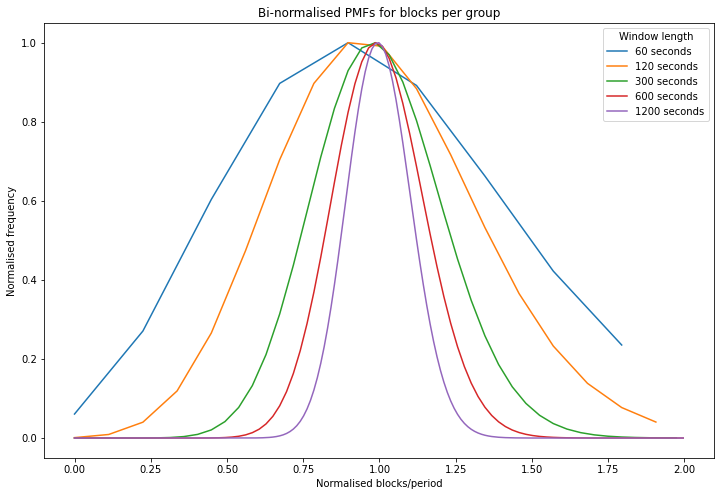

In [4]:
# investigate gas supply variability

from scipy.stats import poisson

block_frequency = (END_BLOCKNUM - START_BLOCKNUM) / (last_block_ts - first_block_ts)

print("Relative number of blocks per group — bounds for 90% interval\n")
print("period (s) | lower | upper")
print("--------------------------")
fig, ax = plt.subplots(figsize=(12, 8))
for group_period in [60, 120, 300, 600, 1200]: # 1 min, 2 mins, 5 mins, 10 mins, 20 mins
    x = []
    pmf = []
    expected_blocks_per_period = block_frequency * group_period
    for i in range(int(expected_blocks_per_period * 2 + 1)):
        x.append(i / expected_blocks_per_period)
        pmf.append(poisson.pmf(i, expected_blocks_per_period))
    
    norm = max(pmf)
    ax.plot(x, [p / norm for p in pmf], label=f"{group_period} seconds")
    interval = poisson.interval(0.9, expected_blocks_per_period)
    lower = 100 * interval[0] / expected_blocks_per_period
    upper = 100 * interval[1] / expected_blocks_per_period
    print(f"{group_period:>10} | {lower:>4.0f}% | {upper:>4.0f}%")

ax.set_title("Bi-normalised PMFs for blocks per group")
ax.set_xlabel("Normalised blocks/period")
ax.set_ylabel("Normalised frequency")
ax.legend(title="Window length");

So, with all the above in mind, let's take a look at the data itself. We'll be looking at the 750,000 blocks before the London hard fork, and 750,000 after the London hard fork, for a total of 1.5m blocks spanning about 7.5 months from early April until late November.

## Median Gas Prices

The first chart below shows the median gas price paid within each analysis window (a 5 minute window has been applied). Because gas demand has a cyclical 24-hour element to it, there's also a 24-hour rolling mean applied to this data to smooth out the intra-day fluctuations. Again, the London hard fork is marked with a dashed red line.

This chart shows a few things:

1. The London hard fork followed a period of relatively low gas prices in June and July.
1. After the London hard fork, gas prices remained within the historically observed range, albeit mostly above the June/July lull. There is nothing in the data to suggest that EIP-1559 actually caused median gas prices to rise.
1. Users of the new "type 2" transaction type introduced by EIP-1559 pay on average less than users of legacy transactions, but the difference is relatively small when compared to the fluctuations in gas price due to fluctuating demand.

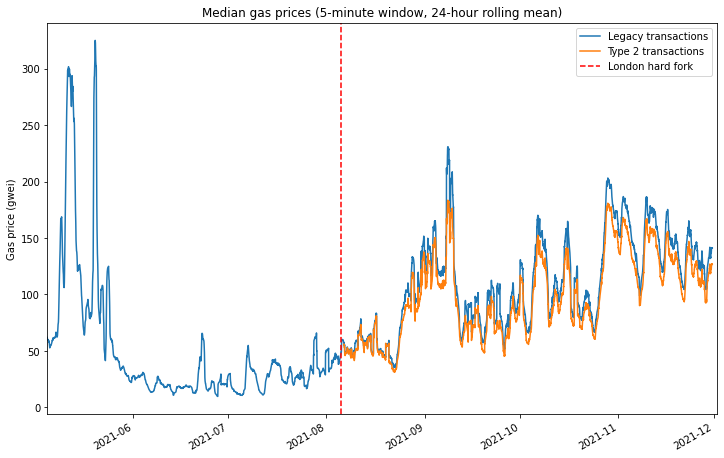

In [5]:
# investigate median gas price and normalised iqr

ws = window_series[1]
x = [
    datetime.utcfromtimestamp(ws.start_ts + i * ws.period) for i in range(ws.numperiods)
]
series_legacy = [list(i) for i in zip(*ws.quantile_series_legacy)]
series_type2 = [list(i) for i in zip(*ws.quantile_series_type2)]

df_legacy = pd.DataFrame({
    '1st quartile':series_legacy[0],
    'median':      series_legacy[1],
    '3rd quartile':series_legacy[2]
}, index=x)

df_type2 = pd.DataFrame({
    '1st quartile':series_type2[0],
    'median':    series_type2[1],
    '3rd quartile':series_type2[2]
}, index=x)

r = 24 * 60 * 60 // ws.period
fig, ax = plt.subplots(figsize=(12, 8))
df_legacy['median'].rolling(r).mean().divide(1e9).plot(ax=ax, label="Legacy transactions")
df_type2['median'].rolling(r).mean().divide(1e9).plot(ax=ax, label='Type 2 transactions')
ax.axvline(london_dt, color='r', linestyle='dashed', label="London hard fork")
ax.set_title("Median gas prices (5-minute window, 24-hour rolling mean)")
ax.set_ylabel("Gas price (gwei)")
ax.set_xlim(xmin=datetime(2021,5,5), xmax=datetime(2021,12,2))
ax.legend();

## Median-Normalised Interquartile Range

Looking at the 'raw' median prices is useful in that it allows us to see that EIP-1559 has fundamentally not changed the average gas price level — at least not in any way that can be detected compared with the extreme volatility normally observed in the Ethereum gas market. However our exam question was about the level of *overpayment* which results under each fee market mechanism. As explained previously, this question is difficult to answer due to the presence of outliers in the data. However, we will assume that if the gas market is more efficient, then the interquartile range will be compressed.

The interquartile range tends to grow when then the gas price increases. Therefore, to make it easier to make a sensible comparison over time, across a range of gas market conditions, we would like find some way to *normalise* this data. [Plotting the data](iqr-vs-median.ipynb) suggests a weak linear relationship between median price and interquartile range. Therefore, to remove this effect, we simply divide the interquartile range by the average (median) fee level.

This has been done in the below plot using the same 5-minute analysis window and 24-hour rolling mean as before. Here we see quite a clear effect. Type 2 transactions show a consistently lower normalised variability than legacy transactions, even comparing legacy transactions *before* the London hard fork with type 2 transactions from *after* the London hard fork. This is a good indication that EIP-1559 *is* achieving its stated aim of a more efficient gas market and therefore reducing overpayment.

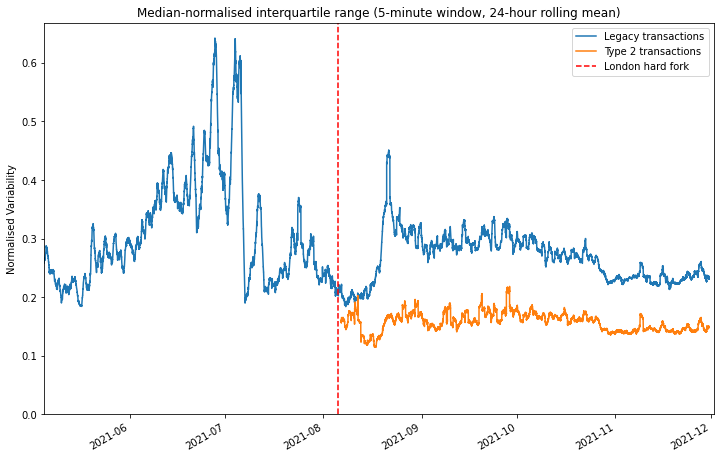

In [6]:
# plot median-normalised interquartile range

norm_range_legacy = (df_legacy['3rd quartile'] - df_legacy['1st quartile']) / df_legacy['median']
norm_range_type2 = (df_type2['3rd quartile'] - df_type2['1st quartile']) / df_type2['median']

fig, ax = plt.subplots(figsize=(12, 8))
norm_range_legacy.rolling(r).mean().plot(ax=ax, label="Legacy transactions")
norm_range_type2.rolling(r).mean().plot(ax=ax, label='Type 2 transactions')
ax.axvline(london_dt, color='r', linestyle='dashed', label="London hard fork")
ax.set_title("Median-normalised interquartile range (5-minute window, 24-hour rolling mean)")
ax.set_ylabel("Normalised variability")
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=datetime(2021,5,5), xmax=datetime(2021,12,2))
ax.legend();

## Comparing like-for-like

While the reduced variability in the prices of type 2 transactions gives us a decent indication that the EIP-1559 gas market is more efficient, it doesn't give us a good sense of what this means in practical terms. How much can you save by switching to the new model? To explore this question, we're going to take a look at data relating to a specific transaction type: deposits to [Tornado Cash](https://tornado.cash/). By focusing in on a specific transaction type, we can be confident that we are making a straight comparison and hopefully draw some conclusions about.

As a quick primer for those unfamiliar, Tornado Cash is trustless mixer for ether and several ERC-20 tokens, allowing users to gain a level of privacy by temporarily pooling their funds with other users. Users deposit their ether/tokens into a pool, and then withdraw the same amount of tokens from the pool at a later date, to a different address. Zero-knowledge proofs are used to allow a user to withdraw from the pool by proving they have made a deposit (which has not yet been withdrawn) without revealing any information about *which* deposit they made.

Tornado Cash transactions are a good choice for us here because Tornado Cash deposits will never be part of a priority gas auction. Indeed users of Tornado Cash will generally want to leave their funds in the pool for a period of time for increased privacy, since depositing and withdrawing in quick succession could link their deposit and withdrawal addresses, so they are unlikely to place a high premium on rapid inclusion. Furthermore the value to the user of a Tornado Cash deposit transaction depends very little on any other activity occurring on-chain. This may be contrasted with a decentralised exchange or NFT mint transaction which may be extremely time-sensitive.

As we saw previously, gas demand and therefore price is extremely volatile. So unfortunately we can't make any sensible comparison between transactions occurring before and after the London hard fork — any differences would be completely obscured by the wide swings in gas price which are the result of fluctuating demand. Given the relatively small number of transactions involved, even looking at 5-minute analysis windows is no good. However, when we look at legacy and type 2 transactions occurring in the *same block*, a pattern does emerge.

A sample of Tornado Cash transactions have been extracted using [TrueBlocks](https://trueblocks.io/). The scatter plot below shows the average percentage difference in fees between legacy and type 2 Tornado Cash transactions. So points below the dashed red line indicate that the type 2 transactions in that block were cheaper than the legacy transactions. We see that in the early days after the London hard fork it does not appear that type 2 transactions provide any advantage. Indeed a handful of outlier points in mid September show a greater that 40% premium for type 2 transactions! What's going on here?

In [7]:
# load Tornado Cash data

with open('tornado_deposits.json') as f:
    t = json.load(f)
    
tc_txs = sorted(t['data'], key=lambda k: (k['blockNumber'], k['transactionIndex']))

average difference in fees from legacy -> type 2 transactions: -6.4%


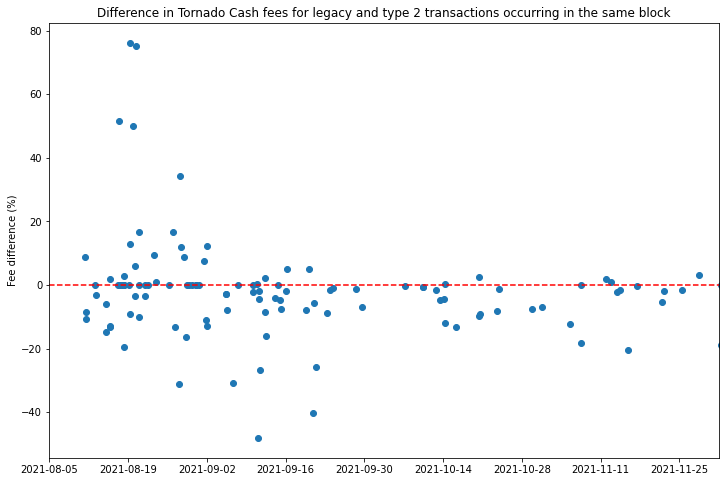

In [8]:
# investigate gas prices for Tornado Cash transactions

dt_lookup = {}
legacy_lookup = {}
type2_lookup = {}
first_day = datetime.utcfromtimestamp(tc_txs[0]['timestamp']).date()
last_day = datetime.utcfromtimestamp(tc_txs[-1]['timestamp']).date()
num_days = (last_day - first_day).days + 1
legacy_counts = [0] * num_days
equiv_counts = [0] * num_days
type2_counts = [0] * num_days
for tx in tc_txs:
    bn = tx['blockNumber']
    daynum = (datetime.utcfromtimestamp(tx['timestamp']).date() - first_day).days
    if bn < LONDON_BLOCKNUM:
        continue
    price = tx['receipt']['effectiveGasPrice']
    if tx['maxFeePerGas'] == 0:
        legacy_counts[daynum] += 1
        if bn in legacy_lookup:
            legacy_lookup[bn] += [price]
        else:
            legacy_lookup[bn] = [price]
        if not bn in dt_lookup:
            dt_lookup[bn] = datetime.utcfromtimestamp(tx['timestamp'])
    else:
        if tx['maxPriorityFeePerGas'] != tx['maxFeePerGas']:
            type2_counts[daynum] += 1
        else:
            equiv_counts[daynum] += 1
        if bn in type2_lookup:
            type2_lookup[bn] += [price]
        else:
            type2_lookup[bn] = [price]
        if not bn in dt_lookup:
            dt_lookup[bn] = datetime.utcfromtimestamp(tx['timestamp'])

x = []
y = []
sumpercdiff = 0
count = 0
for bn in legacy_lookup:
    if bn in type2_lookup:
        lg_price = sum(legacy_lookup[bn]) / len(legacy_lookup[bn])
        t2_price = sum(type2_lookup[bn]) / len(type2_lookup[bn])
        percdiff = 100 * t2_price / lg_price - 100
        x += [dt_lookup[bn]]
        y += [percdiff]
        if dt_lookup[bn] > datetime(2021,9,10):
            sumpercdiff += percdiff
            count += 1

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x, y)
ax.set_title('Difference in Tornado Cash fees for legacy and type 2 transactions occurring in the same block')
ax.set_ylabel('Fee difference (%)')
ax.set_xlim(xmin=first_day, xmax=last_day)
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
ax.axhline(0, color='r', linestyle='dashed')

print(f"average difference in fees from legacy -> type 2 transactions: {sumpercdiff / count:.1f}%")

If we look at the proportions of Tornado Cash deposit transactions of different types (below) we see that during August and early September, most of the type 2 transactions were in fact "legacy-equivalent" transactions with the fee cap and priority fee set to the same value. As mentioned previously, the presence of these transactions indicates that the Tornado Cash front end was still using an old version of web3.js. If we dig into their commit history, we find that the web3.js version was bumped up to a release that supported EIP-1559 transactions [on 30 August](https://github.com/tornadocash/provider/commit/c3cac21dd19cfbd81de9f2b6e265335530084631). A few days later, by 10 September, the proportion of legacy-equivalent transactions has plummeted, indicating that the live version of the Tornado Cash interface was by that stage upgraded to handle type 2 transactions properly.

With this in mind, it makes more sense to look at the blocks containing Tornado Cash deposits which occur after this point, of which the vast majority are below the line, indicating a discount for users submitting type 2 transactions. **The average discount accross all of these blocks was 6.4%**.

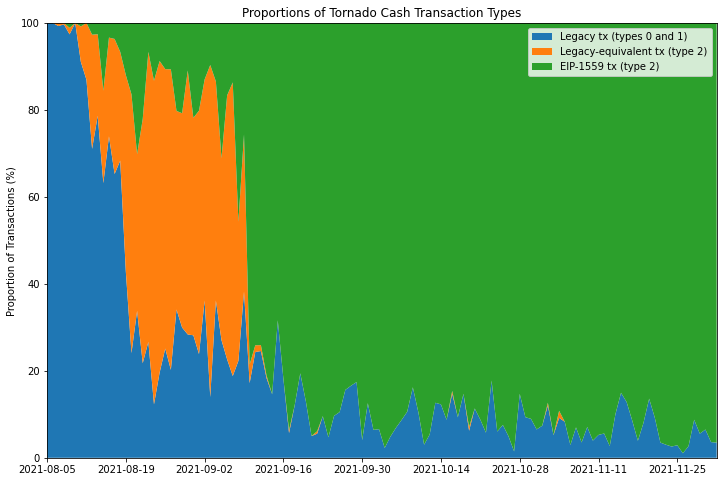

In [9]:
# plot changing proportions of legacy/type2 transactions on Tornado Cash

dates = [first_day + timedelta(days=i) for i in range(num_days)]
fig, ax = plt.subplots(figsize=(12,8))
legacy_frac = [100 * l / (l+e+t) for l, e, t in zip(legacy_counts, equiv_counts, type2_counts)]
equiv_frac = [100 * e / (l+e+t) for l, e, t in zip(legacy_counts, equiv_counts, type2_counts)]
type2_frac = [100 * t / (l+e+t) for l, e, t in zip(legacy_counts, equiv_counts, type2_counts)]
labels = ['Legacy tx (types 0 and 1)', 'Legacy-equivalent tx (type 2)', 'EIP-1559 tx (type 2)']
ax.stackplot(dates, legacy_frac, equiv_frac, type2_frac, labels=labels)
ax.set_title('Proportions of Tornado Cash Transaction Types')
ax.set_ylabel('Proportion of Transactions (%)')
ax.set_xlim(xmin=first_day, xmax=last_day)
ax.set_ylim(ymin=0, ymax=100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
ax.legend();

# Prompt Inclusion
The second question to examine is whether, since the London hard fork, users are better able to get their transactions included quickly. Anecdotally, this seemed to be the case for my own usage, and a few people on Twitter made similar observations soon after the London hard fork. The question is how to determine how long transactions take to get included on the blockchain, since in general, transactions include no information about when they were first transmitted. A tweet from Uniswap founder Hayden Adams caught my eye:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Yup, Uniswap v3 swap tx fail rate is at an all time low of 6.7% right now <br><br>Historically has averaged between 10-15%<br><br>This was always one of the primary benefits of EIP-1559 <a href="https://t.co/IC6hYWnZ2o">https://t.co/IC6hYWnZ2o</a></p>&mdash; hayden.eth 🦄 (@haydenzadams) <a href="https://twitter.com/haydenzadams/status/1431291143065636870?ref_src=twsrc%5Etfw">August 27, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

Here, Hayden is arguing that faster inclusion of transactions on Uniswap v3 is causing fewer of these transactions to fail. But why would faster inclusion stop these transactions from failing? There are two main reasons:

1. Movement in the market of the asset being exchanged could result in the available price being outside the limits set by the user by the time the transaction is included. This would cause the transaction to fail. The longer it takes for the transaction to be included, the more likely such market movement is to have occurred.
1. Transactions submitted on Uniswap have a "deadline" parameter which ensures that transactions eventually expire. This prevents a zombie transaction being executed long after a user has forgotten about it. If such a transaction is included after the deadline, it will fail.

## Uniswap v3 Error Rate

A decrease in the transaction failure rate could therefore be explained by faster inclusion of users' transactions. There are various other factors that can cause a transaction to fail, such as if users attempt to execute a swap for which they don't have sufficient funds, or if they set the gas limit on the transaction too low. Sudden market movements can also cause transactions to fail even if they are included quickly. So we shouldn't assume that changes in the failure rate can only be explained by the speed of transaction inclusion. With all this in mind, let's take a look at the failure rate for Uniswap v3 transactions. Again, we'll be using [TrueBlocks](https://trueblocks.io/) to extract the relevant data.

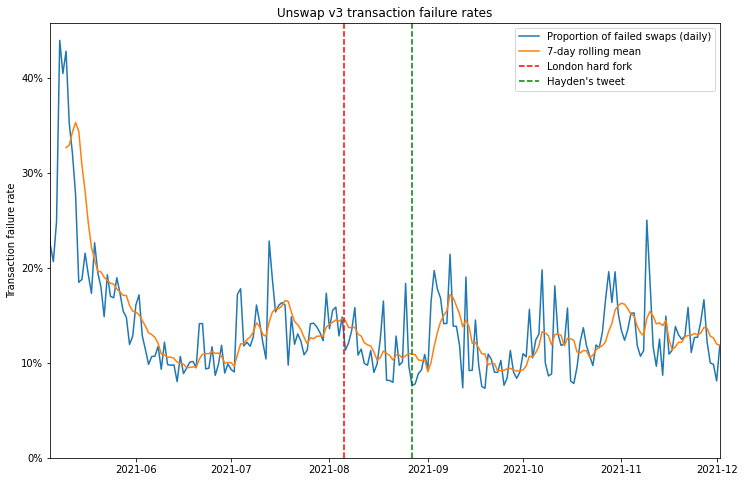

In [10]:
# look at error rates for Uniswap v3 transactions

swaps = []
with open('univ3-swaps.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        inclusion_ts = int(row[1])
        error = int(row[2])
        deadline_ts = int(row[4])
        inclusion_dt = datetime.utcfromtimestamp(inclusion_ts)
        remainder = deadline_ts - inclusion_ts
        swaps.append([inclusion_dt, error, remainder])

start_date = swaps[0][0].date()
num_days = (swaps[-1][0].date() - start_date).days + 1

daily_tx_count = [0] * num_days
daily_exp_count = [0] * num_days
daily_err_count = [0] * num_days
daily_remainders = [[] for _ in range(num_days)]
for dt, error, remainder in swaps:
    daynum = (dt.date() - start_date).days
    daily_tx_count[daynum] += 1
    daily_err_count[daynum] += error
    daily_exp_count[daynum] += 1 if remainder < 0 else 0
    daily_remainders[daynum].append(remainder)

dates = [start_date + timedelta(days=i) for i in range(num_days)]
err_frac = [e / t if t > 0 else None for e, t in zip(daily_err_count, daily_tx_count)]
exp_frac = [e / t if t > 0 else None for e, t in zip(daily_exp_count, daily_tx_count)]
med_remainder = [median(r) for r in daily_remainders]
df = pd.DataFrame({'err_frac': err_frac, 'exp_frac': exp_frac, 'med_remainder': med_remainder}, index=dates)

fig, ax = plt.subplots(figsize=(12, 8))
df['err_frac'].plot(ax=ax, label="Proportion of failed swaps (daily)")
df['err_frac'].rolling(7).mean().plot(ax=ax, label="7-day rolling mean")
ax.axvline(london_dt, color='r', linestyle='dashed', label="London hard fork")
ax.axvline(datetime(2021,8,27), color='g', linestyle='dashed', label="Hayden's tweet")
ax.set_title('Unswap v3 transaction failure rates')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel('Transaction failure rate')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=datetime(2021,5,5), xmax=datetime(2021,12,2))
ax.legend();

So it appears that swap failure rates did come down in the month or so after the London hard fork, and at the time that Hayden tweeted about it, they had reached their lowest level since the launch of Uniswap v3. However, this appears to have been something of a fluke since, in the months that followed, failure rates didn't show any particular trend, staying in roughly the range they had been in the couple of months *before* London.

## Uniswap v3 Expiry Rate

So can we do any better? Maybe. Remember that Uniswap v3 transactions include a *deadline* parameter, after which the transactions will expire, and fail if included. Using this parameter, we can filter for the transactions which failed specifically because they expired. If a lower proportion of transactions expire, it is reasonable to infer that some of these transactions have been included more quickly than they would have been in the previous gas market.

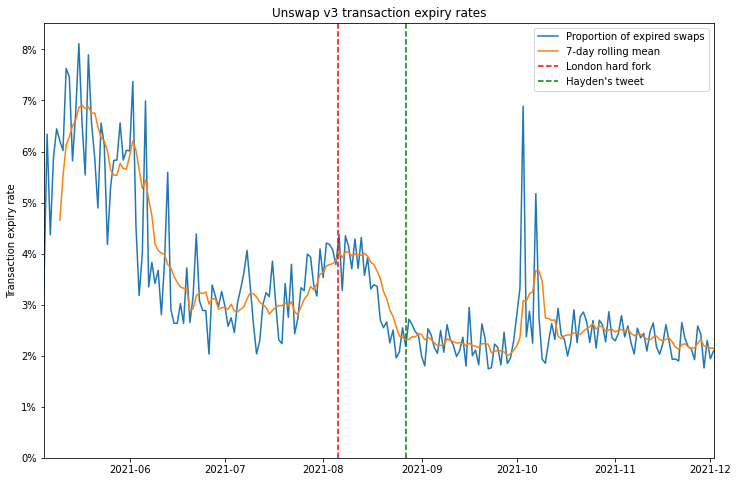

In [11]:
# plot expiry rates for Uniswap v3 transactions

fig, ax = plt.subplots(figsize=(12, 8))
df['exp_frac'].plot(ax=ax, label="Proportion of expired swaps")
df['exp_frac'].rolling(7).mean().plot(ax=ax, label="7-day rolling mean")
ax.axvline(london_dt, color='r', linestyle='dashed', label="London hard fork")
ax.axvline(datetime(2021,8,27), color='g', linestyle='dashed', label="Hayden's tweet")
ax.set_title('Unswap v3 transaction expiry rates')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel('Transaction expiry rate')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=datetime(2021,5,5), xmax=datetime(2021,12,2))
ax.legend();

The plot showing the proportion of expired swaps each day seems to show a more durable reduction since the London hard fork. Again, there is a steep drop immediately after London, but when we zoom out, we might wonder whether this change is due to the fee market change, or whether the decrease is part of a trend that began well before.

## Uniswap v3 Remaining Time to Expiry

Maybe we can use the Uniswap v3 *deadline* parameter a bit more cleverly. Rather than looking only at the proportion of transactions which have expired, we could look at the difference between the transaction's deadline and the timestamp of the block in which it was included, the "remaining time to expiry". By taking the median of this quantity over all swap transactions in a 24-hour period, we can look for any difference resulting from the fee market change. If transactions are being included more quickly, we would expect them to have a longer remaining time to expiry, assuming the initial validity time set for new swaps is unchanged.

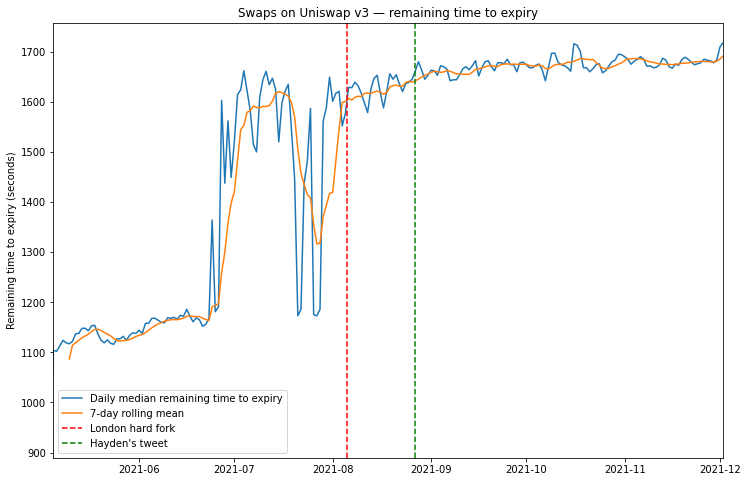

In [12]:
# plot the median remaining time to expiry

fig, ax = plt.subplots(figsize=(12, 8))
df['med_remainder'].plot(ax=ax, label="Daily median remaining time to expiry")
df['med_remainder'].rolling(7).mean().plot(ax=ax, label="7-day rolling mean")
ax.axvline(london_dt, color='r', linestyle='dashed', label="London hard fork")
ax.axvline(datetime(2021,8,27), color='g', linestyle='dashed', label="Hayden's tweet")
ax.set_title('Swaps on Uniswap v3 — remaining time to expiry')
ax.set_ylabel('Remaining time to expiry (seconds)')
ax.set_xlim(xmin=datetime(2021,5,5), xmax=datetime(2021,12,2))
ax.legend();

Here, we see a general general trend for increasing time to expiry which again *could* be the result of faster transaction inclusion. However again we cannot say that this trend *began* with the London hard fork. Indeed much larger changes seem to occur in the months before London, which could be the result of changes in the Uniswap user interface which sets the deadline parameter.

## Uniswap v2 Approve/Swap Delay

If the swap deadline is unreliable as a way of working out the inclusion delay, are there any on-chain metrics which are less susceptible to UI changes? One idea might be to look at pairs of transactions executed in succession. Again, Uniswap provides us with such an example. Commonly users are required to make two transactions when they want to perform a swap — they first need to approve the ERC-20 token for use on Uniswap, and then make the trade itself. The design of Uniswap v3 has largely eliminated this UI headache by building in "multicall" functionality which allows users to bundle the "approve" and "swap" actions into a single transaction.

However, Uniswap v2 did not have such functionality and although its usage has been in steady decline since the launch of Uniswap v3, it still provides us with a dataset of linked transactions, where users would generally prefer the delay between the transactions to be as short as possible. We're going to focus on trades involving historically one of the most popular ERC-20 tokens on Uniswap — the DAI stablecoin.

We're looking for pairs of transactions where transaction (1) is an "approve" transaction sent to the DAI contract authorising the Uniswap v2 router, and transaction (2) is a "swap" transaction from the same address, sent to the Uniswap v2 router, where DAI is the token being supplied for the trade. Transactions (1) and (2) should also have a consecutive nonce (i.e. no transactions from that account have occurred in between (1) and (2)). Let's start by looking at how many such instances occur:

7412 consecutive / 2552 gapped approve/swap sequences
9964 matches vs 18466 unmatched approvals


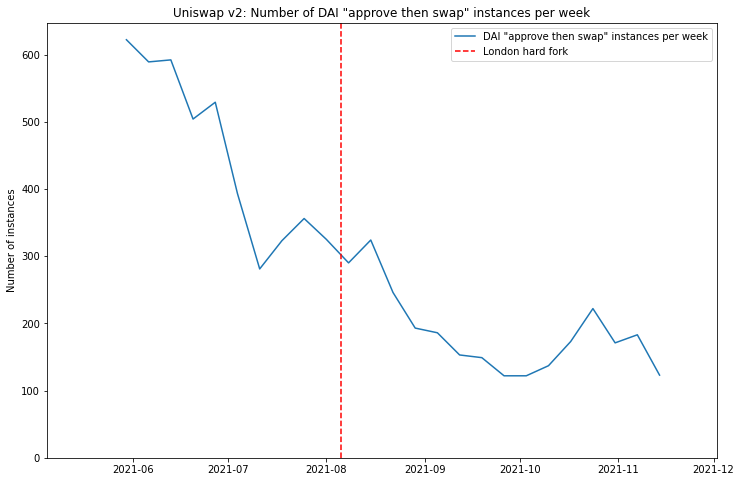

In [13]:
# investigate inclusion delays using Uniswap v2 DAI data, plot instances per week

APPROVALS_FILE = 'dai-approvals-univ2.csv'
SWAPS_FILE = 'univ2-swaps-dai.csv'

#         0                 1                  2         3         4        5       6         7
# [{BLOCKNUMBER}],[{TRANSACTIONINDEX}], [{TIMESTAMP}],[{FROM}],[{NONCE}],[{TO}],[{HASH}],[{ISERROR}]

approvals = {}
with open(APPROVALS_FILE) as f:
    reader = csv.reader(f)
    for row in reader:
        address = row[3]
        iserror = int(row[7])
        if address not in approvals and not iserror:
            timestamp = int(row[2])
            nonce = int(row[4])
            approvals[address] = [nonce, timestamp]

first_swaps = {}
row_count = error_count = 0
swap_iserror = []
with open(SWAPS_FILE) as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        row_count += 1
        timestamp = int(row[2])
        address = row[3]
        iserror = int(row[7])
        swap_iserror += [[timestamp, iserror]]
        if iserror:
            error_count += 1
        if address not in first_swaps:
            nonce = int(row[4])
            first_swaps[address] = [nonce, timestamp]

gapped_count = matched_count = unmatched_approval_count = 0
instances = []
for address in approvals:
    if address in first_swaps:
        matched_count += 1
        approval_nonce, approval_timestamp = approvals[address]
        swap_nonce, swap_timestamp = first_swaps[address]
        if swap_nonce - approval_nonce == 1:
            dt = datetime.utcfromtimestamp(approval_timestamp)
            instances += [[dt, swap_timestamp - approval_timestamp]]
        else:
            gapped_count += 1
    else:
        unmatched_approval_count += 1

print(f"{len(instances)} consecutive / {gapped_count} gapped approve/swap sequences")
print(f"{matched_count} matches vs {unmatched_approval_count} unmatched approvals")

first_swap_dt = datetime.utcfromtimestamp(min(k[1] for k in first_swaps.values()))
last_swap_dt = datetime.utcfromtimestamp(max(k[1] for k in first_swaps.values()))

day0 = first_swap_dt.date()
ndays = (last_swap_dt.date() - day0).days + 1
nweeks = math.ceil(ndays / 7)
weekly_instances = [[] for i in range(nweeks)]
for dt, duration in instances:
    if dt < first_swap_dt or dt > last_swap_dt:
        continue
    weeknum = (dt.date() - day0).days // 7
    if weeknum < 0:
        continue
    weekly_instances[weeknum] += [duration]

dates = [day0 + timedelta(days=i*7) for i in range(nweeks)]
weekly = pd.DataFrame({
    'median': [median(g) for g in weekly_instances],
    'count': [len(g) for g in weekly_instances]
}, index=dates)

fig, ax = plt.subplots(figsize=(12,8))
weekly['count'].plot(ax=ax, label='DAI "approve then swap" instances per week')
ax.set_title('Uniswap v2: Number of DAI "approve then swap" instances per week')
ax.axvline(london_dt, color='r', linestyle='dashed', label="London hard fork")
ax.set_xlim(xmin=datetime(2021,5,5), xmax=datetime(2021,12,2))
ax.set_ylim(ymin=0)
ax.set_ylabel('Number of instances')
ax.legend();

As mentioned above, clearly the usage of Uniswap v2 is on a downward trend over the last few months, resulting in a generally decreasing number of approve/swap pairs being identified over time. For this reason we're going to work with per-week rather than daily statistics — otherwise the data becomes too noisy to be useful as the number of identified instances dwindles.

So now let's look at the median delay time, and see if any impact from the London hard fork can be identified.

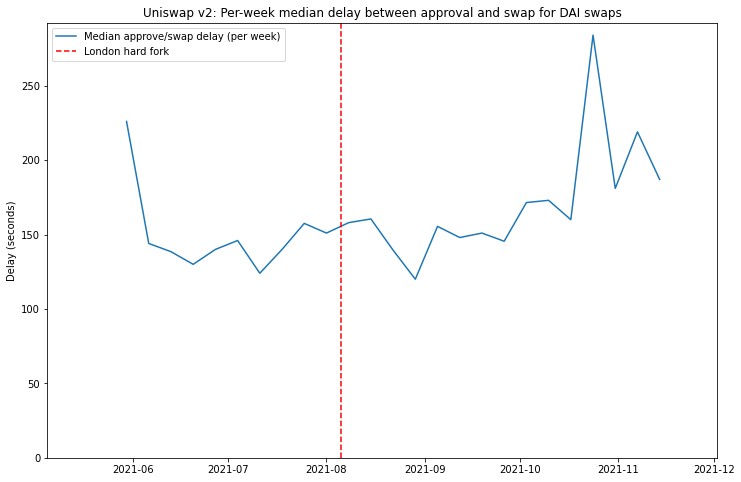

In [14]:
# plot median approve/swap delay time
    
fig, ax = plt.subplots(figsize=(12,8))
weekly['median'].plot(ax=ax, label='Median approve/swap delay')
ax.set_title('Uniswap v2: Per-week median delay between approval and swap for DAI swaps')
ax.set_ylabel('Delay (seconds)')
ax.axvline(london_dt, color='r', linestyle='dashed', label="London hard fork")
ax.set_xlim(xmin=datetime(2021,5,5), xmax=datetime(2021,12,2))
ax.set_ylim(ymin=0)
ax.legend();

In this case the answer seems to be: "no".

Of course, it's worth mentioning that some users do not sit compulsively refreshing Etherscan after submitting their 'approve' transaction so that they can execute the desired swap as soon as the approve goes through (that may just be me). If a user switches their attention to something else after submitting the approve transaction, then the delay between 'approve' and 'swap' is really just a measure of how closely that user is paying attention, rather than how quickly their transactions are being included. On the other hand, a median delay of about 2.5 minutes does seem to suggest many users do respond fairly quickly.

Let's take one final look at this data in a slightly different way. We can make a more detailed pre- vs. post-London comparison by looking at a cumulative histogram. This is plotted below.

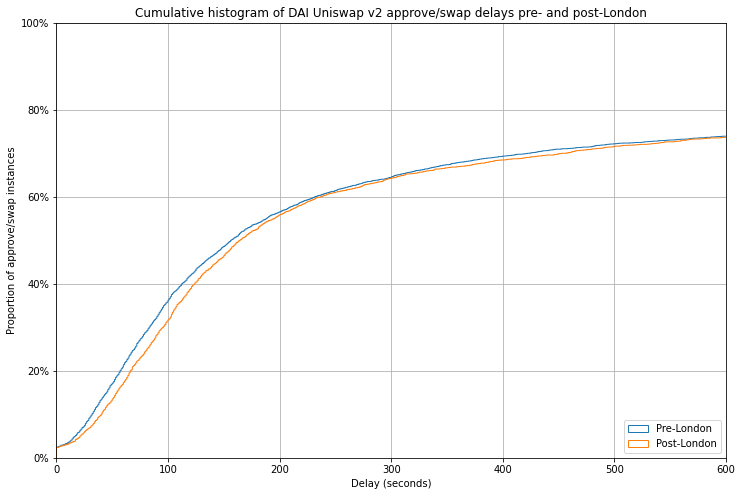

In [15]:
# plot histogram of approve/swap delays on Uniswap v2 pre- and post-London

for i, (dt, _) in enumerate(instances):
    if dt >= london_dt:
        index_after_london = i
        break

df0 = pd.DataFrame([k[1] for k in instances[:index_after_london]])
df1 = pd.DataFrame([k[1] for k in instances[index_after_london:]])

fig, ax = plt.subplots(figsize=(12,8))
bins = [b for b in range(max(k[1] for k in instances))]
df0.hist(bins=bins, ax=ax, density=True, histtype='step', cumulative=True, label='Pre-London')
df1.hist(bins=bins, ax=ax, density=True, histtype='step', cumulative=True, label='Post-London')

ax.set_xlim(xmin=0, xmax=600)
ax.set_ylim(ymin=0, ymax=1)
ax.legend(loc='lower right')
ax.set_title('Cumulative histogram of DAI Uniswap v2 approve/swap delays pre- and post-London')
ax.set_xlabel('Delay (seconds)')
ax.set_ylabel('Proportion of approve/swap instances')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0));

This chart shows that for both pre- and post-London approve/swap pairs, around 75% were executed within 10 minutes (600 seconds) of one another. To the left of this point, the fact that the blue pre-London line sits just above the orange post-London line indicates that in fact approve/swap pairs were actually executed faster *before* the London hard fork than after it. The effect is very slight, and could be explained by any number of other factors including changes in user behaviour, or changes to the population of users who are actually using Uniswap v2 over the last few months. But certainly it does not indicate any significant impact from the introduction of EIP-1559.

# Conclusions

So what does this all mean? Is there something missing from my analysis, or were intuitions/anecdotes from myself and others that transaction inclusion has got faster since the London hard fork simply wrong?

Possibly. However — and I have no clever ways of proving this — my suspicion is  that I and others like me are actually not "typical" users. In general I go to some effort to minimise my transaction fees, using resources such as [ETH Gas Station](https://ethgasstation.info/) to look at prevailing fee levels, and usually adjusting downwards from the suggested gas price using the "advanced options" in Metamask. Most users presumably do not delve into the advanced features of their wallet, instead accepting the defaults — indeed in a discussion held on 10 September (so *after* the London hard fork), Metamask UX designer Jake Haugen [commented](https://www.youtube.com/watch?v=YtkU2773K6w&t=154s) that in the previous 7 days only 20% of users had clicked the "advanced options" button.

While historically my stingy approach has allowed me to minimise what I spend on transactions, it has on many occasions caused me to wait a *long* time when I have slightly misjudged the fee during a period of rising gas prices. I'm no expert in the transaction pricing mechanisms used by Metamask and other wallets, but my belief is that pre-London, they likely built in more of a margin than I typically would when I choose my own gas price — if new users had the same experience as me of frequently stuck transactions, they would rightly complain about an inadequate user experience.

However, since the London hard fork I, and users like me, no longer feel the need to tinker with the gas price on my transactions. I am happy that the defaults will not cause me to overpay, and I am likely to get my transaction included in the next block — except in highly dynamic short periods which still periodically occur upon the launch of some popular NFT from a provider who has yet to understand how to design an [effective NFT launch](https://www.paradigm.xyz/2021/10/a-guide-to-designing-effective-nft-launches/).

The fact that the gas market now is more efficient is borne out by the significantly lower pricing variability seen across 5-minute windows, demonstrated in the first part of this article. It seems as though the prompt inclusion problem had already been largely solved for most users by wallet providers, by overpaying with generous buffers on gas prices. However, since the deployment of EIP-1559, users get to enjoy the benefits of prompt inclusion *without* overpaying for them.

# Acknowledgements

Many thanks to [Thomas Jay Rush](https://twitter.com/tjayrush) for [helping me](https://medium.com/coinmonks/commanding-the-line-ca5fe3496ae1) to use the fantastic [TrueBlocks](https://trueblocks.io/) transaction scraper. I'd recommend anyone doing similar analysis work to give it a try. Also thank you to [Tim Beiko](https://twitter.com/TimBeiko) and [Barnabé Monnot](https://twitter.com/barnabemonnot) for accepting my pitch to take on this analysis, and for your feedback.